In [31]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.ghostnetv2 import GhostNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [32]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [33]:
artifact_path = Path("../../artifacts/ghostnetv2")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [34]:
device = torch.device("cuda:0")

# data

In [35]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [36]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [37]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [38]:
num_class = 43

In [39]:
len(train_dataset)

26640

9


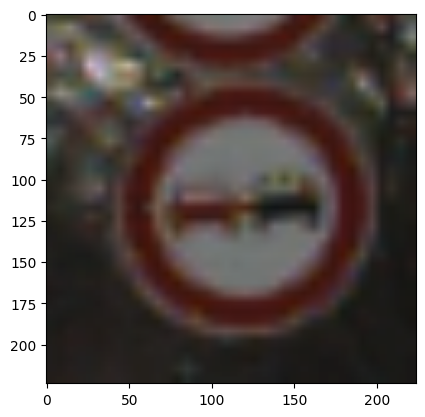

In [40]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [41]:
model = GhostNetV2(output_size=num_class).to(device)

In [42]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
GhostNetV2                                                        --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                432
│    └─BatchNorm2d: 2-2                                           32
│    └─ReLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─GhostLayerV2: 2-4                                          --
│    │    └─ResBlock: 3-1                                         1,008
│    └─GhostLayerV2: 2-5                                          --
│    │    └─ResBlock: 3-2                                         3,996
│    └─GhostLayerV2: 2-6                                          --
│    │    └─ResBlock: 3-3                                         5,328
│    └─GhostLayerV2: 2-7                                          --
│    │    └─ResBloc

# training

In [43]:
epoches = 10
acc_iters = 256 / BATCH_SIZE

In [44]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [45]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [46]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [47]:
training_loss = trainer.run(train_loader, model, optim, criterion, scheduler)

100%|██████████| 416/416 [01:32<00:00,  4.49it/s]


epoch 1 : 0.008227540855072081


100%|██████████| 416/416 [01:35<00:00,  4.37it/s]


epoch 2 : 0.0016881698408304567


100%|██████████| 416/416 [01:31<00:00,  4.55it/s]


epoch 3 : 0.0003552259967748866


100%|██████████| 416/416 [01:29<00:00,  4.67it/s]


epoch 4 : 0.0002092289689917729


100%|██████████| 416/416 [01:28<00:00,  4.68it/s]


epoch 5 : 0.00013189696975665847


100%|██████████| 416/416 [01:34<00:00,  4.40it/s]


epoch 6 : 0.00012162711052190808


100%|██████████| 416/416 [01:36<00:00,  4.32it/s]


epoch 7 : 7.013746039064017e-05


100%|██████████| 416/416 [01:29<00:00,  4.63it/s]


epoch 8 : 8.689077424806923e-05


100%|██████████| 416/416 [01:30<00:00,  4.62it/s]


epoch 9 : 9.63496783403282e-05


100%|██████████| 416/416 [01:37<00:00,  4.25it/s]

epoch 10 : 4.205680069392114e-05


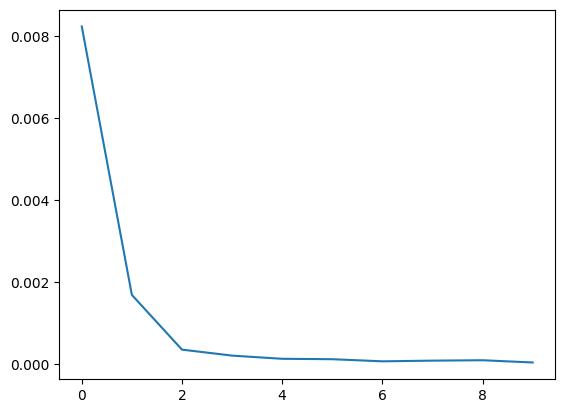

In [48]:
plt.plot(training_loss)

# inference

In [49]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [50]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [51]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [52]:
evaluator = ClassificationEvaluator(num_class, device)

In [53]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:28<00:00,  7.00it/s]

[[ 53   3   0 ...   0   0   0]
 [  0 709   9 ...   0   0   0]
 [  0   1 745 ...   0   0   0]
 ...
 [  0   1   0 ...  85   0   0]
 [  0   0   0 ...   0  58   0]
 [  0   0   0 ...   0  15  75]]


In [54]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.8833333333333333
1         : 0.9847222222222223
2         : 0.9933333333333333
3         : 0.8644444444444445
4         : 0.9393939393939394
5         : 0.9301587301587302
6         : 0.8266666666666667
7         : 0.9711111111111111
8         : 0.9466666666666667
9         : 1.0
10        : 0.9939393939393939
11        : 0.9880952380952381
12        : 0.9840579710144928
13        : 0.9972222222222222
14        : 1.0
15        : 0.9904761904761905
16        : 0.9866666666666667
17        : 1.0
18        : 0.9435897435897436
19        : 0.8666666666666667
20        : 0.7
21        : 0.5555555555555556
22        : 0.7583333333333333
23        : 0.9933333333333333
24        : 0.9333333333333333
25        : 0.9395833333333333
26        : 0.9888888888888889
27        : 0.5
28        : 0.8933333333333333
29        : 1.0
30        : 0.24666666666666667
31        : 0.9592592592592593
32        : 1.0
33        : 0.8142857142857143
34        : 0.925
35        : 0.9615384615384616
3

In [55]:
per_class_acc.mean()

0.8850577172050883

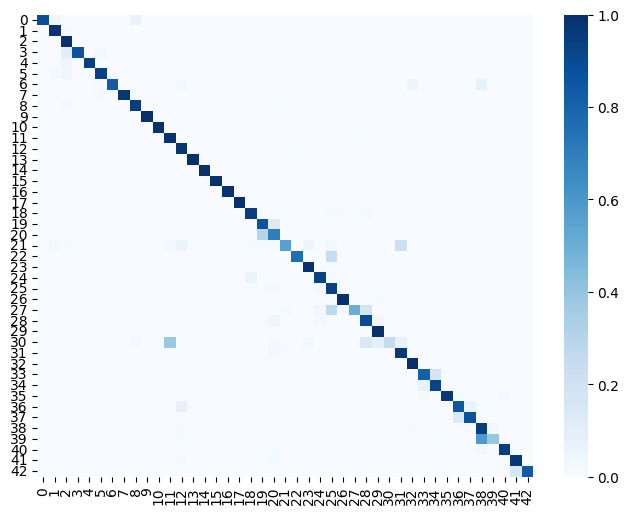

In [56]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [57]:
model_path = artifact_path / f'ghostnetv2.pth'

In [58]:
torch.save(model.state_dict(), model_path)

In [59]:
get_file_size(model_path)

'19.32MiB'

In [60]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>